In [29]:
import numpy as np
import pandas as pd
import regex as re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

# Import estimators
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

# Import metrics
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score

pd.set_option('display.max_columns', None)

In [2]:
path_interim = '/home/matteo@COPPET/Documents/data_science/projects/housing_prices_firenze/data/interim/'

In [3]:
df = pd.read_excel(path_interim+'data.xlsx')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8714 entries, 0 to 8713
Data columns (total 59 columns):
 #   Column                                     Non-Null Count  Dtype         
---  ------                                     --------------  -----         
 0   Tipologia                                  8714 non-null   object        
 1   Zona                                       8714 non-null   object        
 2   Stato                                      8714 non-null   object        
 3   Prezzo_EUR                                 8714 non-null   int64         
 4   Superficie_m2                              8714 non-null   int64         
 5   Prezzo_per_m2                              8714 non-null   float64       
 6   Tipo_proprietà                             8714 non-null   object        
 7   Riscaldamento_A_C                          8714 non-null   object        
 8   Tipo_riscaldamento                         8714 non-null   object        
 9   Alimentazione_risca

### 1. Pre-processing

In [4]:
target = 'Prezzo_EUR'

X = df.drop(columns=['Prezzo_per_m2', 'Data_annuncio', 'Superficie_bins']+[target])
y = df[target].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [5]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8714 entries, 0 to 8713
Data columns (total 55 columns):
 #   Column                                     Non-Null Count  Dtype 
---  ------                                     --------------  ----- 
 0   Tipologia                                  8714 non-null   object
 1   Zona                                       8714 non-null   object
 2   Stato                                      8714 non-null   object
 3   Superficie_m2                              8714 non-null   int64 
 4   Tipo_proprietà                             8714 non-null   object
 5   Riscaldamento_A_C                          8714 non-null   object
 6   Tipo_riscaldamento                         8714 non-null   object
 7   Alimentazione_riscaldamento                8714 non-null   object
 8   Classe_energetica                          8714 non-null   object
 9   Ascensore                                  8714 non-null   int64 
 10  Accesso_disabili                    

#### One-hot encoding

In [6]:
OH_cols = ['Tipologia', 'Zona', 'Stato', 'Tipo_proprietà', 'Riscaldamento_A_C', 'Tipo_riscaldamento',
            'Alimentazione_riscaldamento', 'Piano']

# Apply one-hot encoder to each column with categorical data
OH_encoder = OneHotEncoder(handle_unknown='ignore')
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_train[OH_cols]).toarray(),
                             columns=OH_encoder.get_feature_names())
OH_cols_test = pd.DataFrame(OH_encoder.transform(X_test[OH_cols]).toarray(),
                            columns=OH_encoder.get_feature_names())

# One-hot encoding removed index; put it back
OH_cols_train.index = X_train.index
OH_cols_test.index = X_test.index

# Remove categorical columns (will replace with one-hot encoding)
num_X_train = X_train.drop(OH_cols, axis=1)
num_X_test = X_test.drop(OH_cols, axis=1)

# Add one-hot encoded columns to numerical features
X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
X_test = pd.concat([num_X_test, OH_cols_test], axis=1)

#### Ordinal (label) encoding

In [7]:
label_cols = ['Classe_energetica']

# Apply one-hot encoder to each column with categorical data
oe = OrdinalEncoder()

for col in label_cols:
    X_train[col] = oe.fit_transform(X_train[[col]])
    X_test[col] = oe.transform(X_test[[col]])

#### Scaling

In [8]:
num_cols = ['Superficie_m2', 'Anno_costruzione']

scaler = StandardScaler()

X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

### 2. Modeling

####  First model

In [24]:
reg = LinearRegression()
reg.fit(X_train, y_train)
y_train_pred = reg.predict(X_train)

# Train set score
print('Training set score: {}'.format(mean_absolute_error(y_train, y_train_pred)))

# Cross validation score
scores = cross_val_score(reg, X_train, y_train, scoring='neg_mean_absolute_error', cv=10)
print('Mean cross validation score: {}'.format(np.mean(-scores)))

Training set score: 148769.61411562187
Mean cross validation score: 38005904955545.664


#### Other models

In [84]:
reg = Ridge()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_train)

# Train set score
print('Training set score: {}'.format(mean_absolute_error(y_train, y_pred)))

# Cross validation score
scores = cross_val_score(reg, X_train, y_train, scoring='neg_mean_absolute_error', cv=10)
print('Mean cross validation score: {}'.format(np.mean(-scores)))

Training set score: 134270.5248894177
Mean cross validation score: 142490.4077614503


In [85]:
# Random forest feature importance
feature_coefs = reg.coef_
attributes = X_train.columns
sorted(zip(feature_coefs, attributes), reverse=True)

[(538515.4963498343, 'x0_Villa plurifamiliare'),
 (454713.33494423877, 'x7_oltre il decimo'),
 (371390.82714931306, 'Superficie_m2'),
 (234748.31791773022, 'Idromassaggio'),
 (233859.8474104387, 'x0_Villa unifamiliare'),
 (208797.40068658555, 'x6_gpl'),
 (201630.8145107694, 'x3_Intera proprietà, immobile di lusso'),
 (195285.74634689916, 'x1_Michelangelo Porta Romana'),
 (125896.00898778415, 'x3_Immobile di lusso'),
 (107770.77421905752, 'x1_Centro'),
 (97019.00406639383, 'x1_Oltrarno'),
 (87354.07750434086, 'x0_Rustico'),
 (79446.88526254949, 'Num_bagni'),
 (73348.76070500573, 'x1_Bellosguardo Galluzzo'),
 (66381.31013966672, 'x0_Terratetto unifamiliare'),
 (64739.035269447006, 'Impianto tv con parabola satellitare'),
 (59768.09503566343, 'Ascensore'),
 (52393.8190866692, 'x3_Classe immobile signorile'),
 (48575.88542701509, 'Esposizione esterna'),
 (40813.76019687193, 'Num_tot_locali'),
 (39688.061807218575, 'Parzialmente Arredato'),
 (34149.11162533445, 'x7_ultimo'),
 (33629.1976263

In [74]:
# Regularization parameter
alphas = []
train_scores = []
test_scores = []
for i in range(100):
    alpha = i
    alphas.append(alpha)
    
    reg = Ridge(alpha=alpha)
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_train)
    train_scores.append(mean_absolute_error(y_train, y_pred))
    scores = cross_val_score(reg, X_train, y_train, scoring='neg_mean_absolute_error', cv=5)
    test_scores.append(np.mean(-scores))

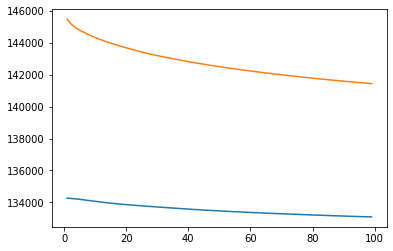

In [77]:
plt.plot(alphas[1:], train_scores[1:])
plt.plot(alphas[1:], test_scores[1:])
plt.show()

In [30]:
reg = Lasso()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_train)

# Train set score
print('Training set score: {}'.format(mean_absolute_error(y_train, y_pred)))

# Cross validation score
scores = cross_val_score(reg, X_train, y_train, scoring='neg_mean_absolute_error', cv=10)
print('Mean cross validation score: {}'.format(np.mean(-scores)))

/home/matteo@COPPET/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 294256209030270.25, tolerance: 323802548661.7974
  positive)


Training set score: 134298.75251692176


/home/matteo@COPPET/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 280245677571575.0, tolerance: 301651268060.2119
  positive)
/home/matteo@COPPET/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 159401609318114.12, tolerance: 239221608188.34763
  positive)
/home/matteo@COPPET/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 287881906257126.1, tolerance: 307594327501.8054
  positive)
/home/matteo@COPPET/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. 

Mean cross validation score: 143012.18043608216


/home/matteo@COPPET/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 184686355985631.62, tolerance: 312544274490.1888
  positive)


In [82]:
reg = RandomForestRegressor(random_state=0)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_train)

# Train set score
print('Training set score: {}'.format(mean_absolute_error(y_train, y_pred)))

# Cross validation score
scores = cross_val_score(reg, X_train, y_train, scoring='neg_mean_absolute_error', cv=10)
print('Mean cross validation score: {}'.format(np.mean(-scores)))

Training set score: 36045.64445416727
Mean cross validation score: 97456.61315403129


In [83]:
# Random forest feature importance
feature_importances = reg.feature_importances_
attributes = X_train.columns
sorted(zip(feature_importances, attributes), reverse=True)

[(0.7128576173627005, 'Superficie_m2'),
 (0.05971292549167245, 'Num_tot_locali'),
 (0.026878987619415814, 'Anno_costruzione'),
 (0.012000923856407475, 'Classe_energetica'),
 (0.010877956546898595, 'x5_pavimento'),
 (0.010446524867845726, 'Num_bagni'),
 (0.00923021664555915, 'x0_Terratetto unifamiliare'),
 (0.008977964334643197, 'x1_Centro'),
 (0.00803110723715981, 'Posti_garage'),
 (0.006572787244345783, 'Cancello elettrico'),
 (0.005949815900075459, 'Posti_esterni'),
 (0.005294476049667009, 'x2_Ottimo / Ristrutturato'),
 (0.005106617119168791, 'x7_2°'),
 (0.005016847518340256, 'Armadio a muro'),
 (0.004664196478893984, 'x2_Buono / Abitabile'),
 (0.0041803619411379805, 'x7_1°'),
 (0.003976660907409468, 'Infissi esterni in vetro / legno'),
 (0.0038232443194036476, 'Ascensore'),
 (0.0038156730505218743, 'Impianto di allarme'),
 (0.003462237536005478, 'Giardino privato'),
 (0.003324422277875946, 'Esposizione esterna'),
 (0.003225490344841157, 'x3_Intera proprietà, classe immobile signoril

In [27]:
reg = KNeighborsRegressor()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_train)

# Train set score
print('Training set score: {}'.format(mean_absolute_error(y_train, y_pred)))

# Cross validation score
scores = cross_val_score(reg, X_train, y_train, scoring='neg_mean_absolute_error', cv=10)
print('Mean cross validation score: {}'.format(np.mean(-scores)))

Training set score: 98228.48374695166
Mean cross validation score: 122690.10215183368


In [78]:
reg = XGBRegressor(random_state=0)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_train)

# Train set score
print('Training set score: {}'.format(mean_absolute_error(y_train, y_pred)))

# Cross validation score
scores = cross_val_score(reg, X_train, y_train, scoring='neg_mean_absolute_error', cv=10)
print('Mean cross validation score: {}'.format(np.mean(-scores)))

[19:49:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training set score: 85039.3763627887
[19:49:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:49:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:49:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:49:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:49:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:49:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:49:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:49:24] WARNING: src/objective/r

### 3. Hyperparameter tuning

In [ ]:
from sklearn.model_selection import GridSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


grid_search = GridSearchCV(rdmf, param_grid, cv=5, verbose=1, scoring='neg_mean_absolute_error')
grid_search.fit(X_train, y_train)